In [1]:
# Importações
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA de fato

In [2]:
# Lendo os arquivos parquet
df_business = pd.read_parquet("../data/yelp_dataset/yelp_academic_dataset_business.parquet")

In [3]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float32
 7   longitude     150346 non-null  float32
 8   stars         150346 non-null  float32
 9   review_count  150346 non-null  uint16 
 10  is_open       150346 non-null  uint8  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float32(3), object(9), uint16(1), uint8(1)
memory usage: 12.5+ MB


> Temos 150.346 registros e 14 colunas.

## Ideias:

- business_id é apenas um idetnificador único para relacionar com as outras tabelas
- name é o nome do negócio -> talvez podemos usar um word embedding para já ter uma separação de categorias
- ~address é o endereço do negócio -> acho que só serve para indicar a distância do negócio para o usuário (filtrar por mais  próximas)~
- city acho que apenas serve para filtrar restaurantes por cidade
- state acho que apenas serve para filtrar restaurantes por estado
- ~postal_code talvez já resuma as 3 ultimas colunas e talvez seja mais facil de estabelecer a distancia do usuário para o restaurante~
- latitude e longitude ~podem ser dropadas~ (ou usadas para georefenciar o endereco, ao inves do postal_code) (vamos usar essa já em conjunto com a lib geopy!)
- stars é a média de estrelas do negócio -> dá para dividir pela mediana e estimar se tá acima ou abaixo do normal
- review_count é a quantidade de reviews do negócio -> dá para estimar algo disso?
- is_open é se o negócio está aberto ou não -> dá para usar isso para filtrar por abertos ou fechados
- attributes -> verificar se o tamanho é fixo ou variável
- categories -> verificar se o tamanho é fixo ou variável
- hours -> verificar se o tamanho é fixo ou variável e usar somente a quantidade de dias abertos

### Verificando a coluna name

In [4]:
df_business.name.describe()

count        150346
unique       114117
top       Starbucks
freq            724
Name: name, dtype: object

> Vários nomes podem se repetir. Não temos muitos nomes repetidos, mas temos alguns.

In [5]:
df_business.name.sample(10)

62838         Freddy's Frozen Custard & Steakburgers
113000                                     Boat Club
32546                              Mama's Vegetarian
27683                Mongkoltepmunee Buddhist Temple
111515                              Black Bear Diner
8427                  Arizona's Interior Innovations
94018                         Abandoned Luncheonette
93957               Pima County Sheriff's Department
82468                                     Branch Out
68727     Gastroenterology Consultants Medical Group
Name: name, dtype: object

> Talvez seja melhor não usar o nome para nada.

### Dropando address

In [6]:
df_business.drop(columns=["address"], inplace=True)

### Verificando city e state

In [7]:
df_business[["city","state"]].describe()

,city,state
count,150346,150346
unique,1416,27
top,Philadelphia,PA
freq,14569,34039


> Como esperado, tem-se muito registros de cidades. Mas apenas 27 estados.

In [8]:
df_business.state.unique()

array(['CA', 'MO', 'AZ', 'PA', 'TN', 'FL', 'IN', 'LA', 'AB', 'NV', 'ID',
       'DE', 'IL', 'NJ', 'NC', 'CO', 'WA', 'HI', 'UT', 'TX', 'MT', 'MI',
       'SD', 'XMS', 'MA', 'VI', 'VT'], dtype=object)

> Apenas estados dos EUA. Mas, pensando bem, podemos dropar esses dados e manter apenas os dados de latitude e longitude, recomendando apenas aqueles restuarantes dentro de um raio arbitrário.

In [9]:
df_business.drop(columns=["city","state"], inplace=True)

In [10]:
df_business.drop(columns=["postal_code"], inplace=True)  # já deleta o codigo postal

### Verificando latitude e longitude

In [11]:
df_business[["latitude","longitude"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   150346 non-null  float32
 1   longitude  150346 non-null  float32
dtypes: float32(2)
memory usage: 1.1 MB


> Todas as linhas possuem latitude e longitude. Não temos nenhum registro nulo. Que maravilha!

### Verificando stars

In [12]:
df_business.stars.describe()

count    150346.000000
mean          3.596724
std           0.974421
min           1.000000
25%           3.000000
50%           3.500000
75%           4.500000
max           5.000000
Name: stars, dtype: float64

> A média está em 3.59, e a mediana em 3.5. Interessante essa distribuição. Vamos ver o histograma:

<AxesSubplot:xlabel='stars', ylabel='Count'>

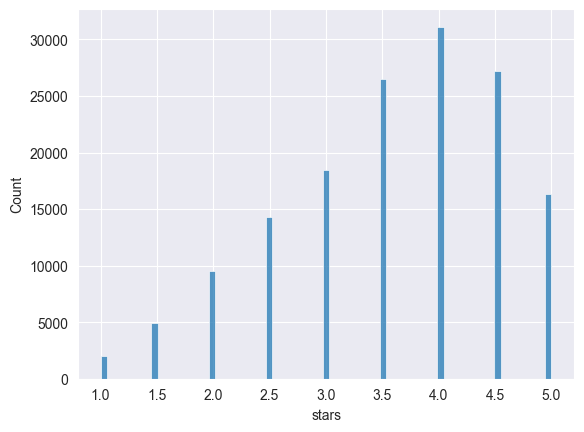

In [13]:
sns.histplot(df_business.stars)

> Um tanto equilibrado, mas com uma leve tendência para 5.0 estrelas.

### Verificando review_count

In [14]:
df_business.review_count.describe()

count    150346.000000
mean         44.866561
std         121.120136
min           5.000000
25%           8.000000
50%          15.000000
75%          37.000000
max        7568.000000
Name: review_count, dtype: float64

Text(0, 0.5, 'Número de reviews')

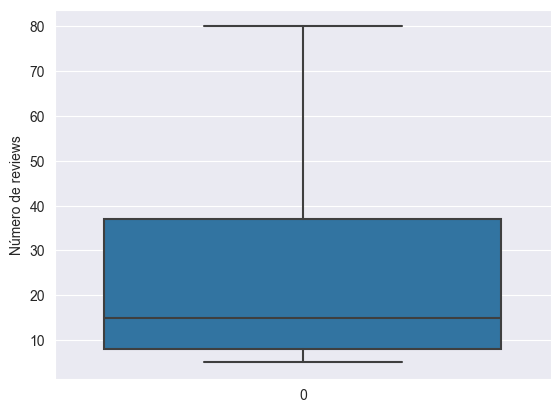

In [15]:
sns.boxplot(data=df_business.review_count, showfliers=False)
plt.ylabel("Número de reviews")

> Vemos que boa parte dos negócios não possuem muitas reviews. Alguns possuem milhares de reviews.

In [16]:
# verificando quantos negócios estão acima do limite superior do boxplot
IQR = df_business.review_count.quantile(0.75) - df_business.review_count.quantile(0.25)
limite_superior = df_business.review_count.quantile(0.75) + 1.5 * IQR

print(f"{df_business[df_business.review_count > limite_superior].shape[0]} possuem mais de {limite_superior} reviews!")


# printando quantos estão abaixo do limite superior
print(f"{df_business[df_business.review_count < limite_superior].shape[0]} possuem menos de {limite_superior} reviews!")

18302 possuem mais de 80.5 reviews!
132044 possuem menos de 80.5 reviews!


In [17]:
# verificando o nome dos negócios com mais de 1000 reviews
df_business[df_business.review_count > 1000].sort_values(by="review_count", ascending=False).name

113731                     Acme Oyster House
112552                          Oceana Grill
91757     Hattie B’s Hot Chicken - Nashville
143157               Reading Terminal Market
147081            Ruby Slipper - New Orleans
                         ...                
123285                 Shrimpys Blues Bistro
54427                    Anthonino's Taverna
137004                    The Camellia Grill
27265                          Killer Poboys
48961                               El Limon
Name: name, Length: 315, dtype: object

> Surge o alerta: temos negócios com muitas avaliações, e outros com pouquíssimas. Talvez isso dê pau na hora de criar os embeddings.

> Pensando aqui, podemos substituir os reviews de cada negócio por uma média dos embeddings de cada review. Não será a melhor abordagem com os lugares que não possuem muitas reviews, mas devo pensar em uma solução ou deixar um embedding identidade.

In [18]:
# verificando quantos lugares tem 0 reviews
df_business[df_business.review_count == 0].shape[0]

0

> Opa, nenhum lugar tem 0 reviews.

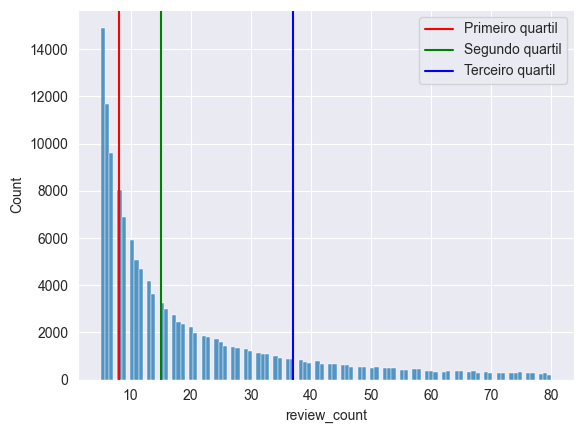

In [19]:
# verificando a distribuição de reviews abaixo do limite superior de reviews
sns.histplot(data=df_business[df_business.review_count < limite_superior].review_count)
# plotando linhas verticais indicando os quartis
plt.axvline(df_business.review_count.quantile(0.25), color="red", label="Primeiro quartil")
plt.axvline(df_business.review_count.quantile(0.5), color="green", label="Segundo quartil")
plt.axvline(df_business.review_count.quantile(0.75), color="blue", label="Terceiro quartil")

plt.legend()

> 50 % dos negócios possuem menos de 20 reviews. Devemos ver quantos text reviews vão existir.

### Verificando is_open

In [20]:
df_business.is_open.value_counts()

1    119698
0     30648
Name: is_open, dtype: int64

> 30 mil negócios fechados e 120 mil abertos. Isso é um problema?
> Talvez simplesmente dropar os negócios fechados não seja uma boa ideia.

### Verificando attributes

In [21]:
# verificando se possuem tamanhos fixos

In [23]:
df_business.attributes.isna().sum()

13744

In [118]:
# porcentagem de nulos
df_business.attributes.isna().sum() / df_business.shape[0]

0.0914158008859564

> Temos valores nulos, que significa 9% dos negócios não possuem atributos.

In [45]:
# verificando se alguma linha não é um dict
not_na = df_business[df_business.attributes.notna()]
not_na[not_na.attributes.apply(lambda x: not isinstance(x, dict))].attributes

Series([], Name: attributes, dtype: object)

In [48]:
not_na.attributes.apply(lambda x: len(x)).describe()

count    136602.0
mean         39.0
std           0.0
min          39.0
25%          39.0
50%          39.0
75%          39.0
max          39.0
Name: attributes, dtype: float64

> Todos possuem o mesmo tamanho. Ou seja, os atributos são dicionários de tamanho fixos.
> No entanto, temos valores nulos.

> Vamos ver quais são os atributos:

In [49]:
# pegando todos os atributos
atributos = set()
for i in df_business.attributes.dropna():
    atributos.update(i.keys())
atributos

{'AcceptsInsurance',
 'AgesAllowed',
 'Alcohol',
 'Ambience',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'BikeParking',
 'BusinessAcceptsBitcoin',
 'BusinessAcceptsCreditCards',
 'BusinessParking',
 'ByAppointmentOnly',
 'Caters',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'GoodForKids',
 'GoodForMeal',
 'HairSpecializesIn',
 'HappyHour',
 'HasTV',
 'Music',
 'NoiseLevel',
 'Open24Hours',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsCounterService',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'Smoking',
 'WheelchairAccessible',
 'WiFi'}

In [50]:
len(atributos)

39

In [115]:
# visualizando um exemplo
df_business.attributes.dropna().sample(1).values[0]

{'AcceptsInsurance': None,
 'AgesAllowed': None,
 'Alcohol': None,
 'Ambience': None,
 'BYOB': None,
 'BYOBCorkage': None,
 'BestNights': None,
 'BikeParking': None,
 'BusinessAcceptsBitcoin': None,
 'BusinessAcceptsCreditCards': 'True',
 'BusinessParking': None,
 'ByAppointmentOnly': None,
 'Caters': None,
 'CoatCheck': None,
 'Corkage': None,
 'DietaryRestrictions': None,
 'DogsAllowed': None,
 'DriveThru': None,
 'GoodForDancing': None,
 'GoodForKids': None,
 'GoodForMeal': None,
 'HairSpecializesIn': None,
 'HappyHour': None,
 'HasTV': None,
 'Music': None,
 'NoiseLevel': None,
 'Open24Hours': None,
 'OutdoorSeating': None,
 'RestaurantsAttire': None,
 'RestaurantsCounterService': None,
 'RestaurantsDelivery': None,
 'RestaurantsGoodForGroups': None,
 'RestaurantsPriceRange2': None,
 'RestaurantsReservations': None,
 'RestaurantsTableService': None,
 'RestaurantsTakeOut': None,
 'Smoking': None,
 'WheelchairAccessible': None,
 'WiFi': None}

> Parece que muitas keys são nulas. Vamos ver quantas são nulas:

In [116]:
# verificando quantas keys são nulas
nulos = 0
total = 0
for i in df_business.attributes.dropna():
    for j in i.keys():
        total += 1
        if i[j] is None:
            nulos += 1

In [120]:
porcentagem = nulos * 100/total

In [122]:
print(f"{porcentagem:.2f}% dos atributos dos dicionários são nulos")

77.35% dos atributos dos dicionários são nulos


### Verificando categories

In [127]:
# verificando se possui nulos
print(f"{df_business.categories.isna().sum() * 100/ df_business.shape[0]:.2f}% dos negócios não possuem categorias")

0.07% dos negócios não possuem categorias


In [129]:
# verificando se possui tamanhos fixos
not_na = df_business[df_business.categories.notna()]
not_na.categories.apply(lambda x: len(x)).describe()

count    150243.000000
mean         59.269384
std          34.615504
min           4.000000
25%          33.000000
50%          52.000000
75%          77.000000
max         503.000000
Name: categories, dtype: float64

In [132]:
# visualizando alguns exemplos
df_business.categories.dropna().sample(5).values

array(['Commercial Real Estate, Local Services, Public Services & Government, Hydro-jetting, Real Estate, Water Heater Installation/Repair, Septic Services, Community Service/Non-Profit, Home Services, Plumbing',
       'Food, Ice Cream & Frozen Yogurt, Pretzels, Desserts',
       'Signmaking, Professional Services, Local Services, Printing Services, Shipping Centers',
       'Sandwiches, Restaurants, Delis', 'Auto Repair, Automotive'],
      dtype=object)

> Podemos extrair os embeddings de cada palavra e criar um embedding médio dessas palavras! Usando o wrod2vec, por exemplo.

### Verificando hours

In [134]:
# verificando se possui nulos
df_business.hours.isna().sum()

23223

In [135]:
# verificando se possui tamanhos fixos
not_na = df_business[df_business.hours.notna()]
not_na.hours.apply(lambda x: len(x)).describe()

count    127123.0
mean          7.0
std           0.0
min           7.0
25%           7.0
50%           7.0
75%           7.0
max           7.0
Name: hours, dtype: float64

> Todos possuem tamanhos fixos

In [136]:
# visualizando exemplos
df_business.hours.dropna().sample(5).values

array([{'Friday': '6:30-20:0', 'Monday': '0:0-0:0', 'Saturday': '8:0-16:0', 'Sunday': None, 'Thursday': '6:30-20:0', 'Tuesday': '6:30-20:0', 'Wednesday': '6:30-20:0'},
       {'Friday': '8:0-18:30', 'Monday': '8:0-18:30', 'Saturday': '8:0-18:30', 'Sunday': '8:0-18:0', 'Thursday': '8:0-18:30', 'Tuesday': '8:0-18:30', 'Wednesday': '8:0-18:30'},
       {'Friday': '10:30-17:0', 'Monday': '0:0-0:0', 'Saturday': '9:0-17:0', 'Sunday': None, 'Thursday': '10:30-17:0', 'Tuesday': '10:30-17:0', 'Wednesday': '10:30-17:0'},
       {'Friday': '0:0-0:0', 'Monday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0'},
       {'Friday': '18:0-19:0', 'Monday': '17:0-19:30', 'Saturday': '12:30-13:30', 'Sunday': '16:0-17:0', 'Thursday': '17:30-18:30', 'Tuesday': '17:30-18:30', 'Wednesday': '18:0-20:0'}],
      dtype=object)

> Vamos desconsiderar por enquanto.

In [137]:
df_business.drop(columns=["hours"], inplace=True)

# Como ficou

In [139]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   latitude      150346 non-null  float32
 3   longitude     150346 non-null  float32
 4   stars         150346 non-null  float32
 5   review_count  150346 non-null  uint16 
 6   is_open       150346 non-null  uint8  
 7   attributes    136602 non-null  object 
 8   categories    150243 non-null  object 
dtypes: float32(3), object(4), uint16(1), uint8(1)
memory usage: 6.7+ MB


> Agora devemos fazer o append das informações dos outros datasets.